In [1]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Get Data

In [2]:
test_df = pd.read_csv('test_simplified.csv')
test_df.shape

(112199, 3)

In [3]:
# Get names of all train csv files with the pattern match below
fnames = glob('train_simplified/*.csv')

In [4]:
rows = 200
# Get n rows from all the csv files and append them into one dataframe
train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=20).columns)
for name in fnames:
    data = pd.read_csv(name, nrows=rows)
    train_df = train_df.append(data)
train_df = train_df.reset_index().drop('index', axis=1)
# Get only those which were correctly recognized
train_df = train_df[train_df['recognized'] == True]

In [5]:
# Convert the drawing column to matrix
train_df['drawing'] = train_df['drawing'].apply(ast.literal_eval)
test_df['drawing'] = test_df['drawing'].apply(ast.literal_eval)

In [6]:
# train_df.head()
# train_df['recognized'].value_counts()

# Draw Sample

In [7]:
train_df.sample(10)

,countrycode,drawing,key_id,recognized,timestamp,word
7106,US,"[[[9, 50, 137], [164, 173, 181]], [[6, 7, 18, ...",6002209202372608,True,2017-03-26 21:24:58.348980,shovel
20502,US,"[[[49, 34, 25, 13, 1, 0, 8, 18, 35, 51, 60, 67...",6365588265893888,True,2017-03-22 04:40:52.674720,blackberry
55260,US,"[[[53, 58, 63], [3, 109, 143]], [[57, 147, 155...",4710603471978496,True,2017-01-30 18:48:45.788020,hat
52621,CZ,"[[[0, 19, 57, 124, 148, 154], [5, 10, 10, 19, ...",4596179834765312,True,2017-03-04 21:34:14.000950,hourglass
11688,GB,"[[[0, 37, 71, 73, 75, 89, 105, 145, 162, 170, ...",5126973787471872,True,2017-03-25 13:59:46.856160,sock
18376,VN,"[[[5, 23, 41, 61, 71, 76, 74, 64, 33, 13, 4, 1...",6463800595185664,True,2017-03-08 14:19:28.245210,peanut
56029,TH,"[[[8, 6, 8, 25, 35, 44, 61, 81, 116, 132, 179,...",6318773575352320,True,2017-03-13 10:16:24.273180,roller coaster
32131,US,"[[[253, 255, 253, 219, 184, 142, 87, 69, 60, 5...",4861451493703680,True,2017-03-14 21:19:33.602050,cannon
61639,US,"[[[2, 0, 24, 29, 31, 34, 25, 10], [94, 155, 15...",4991298303950848,True,2017-03-07 14:28:11.563210,headphones
50188,US,"[[[23, 99, 123, 194, 194], [48, 148, 116, 38, ...",6723060390428672,True,2017-03-09 16:40:27.760460,elbow


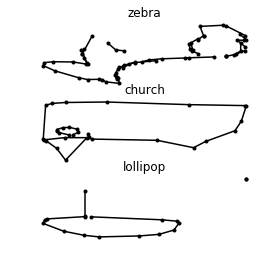

In [8]:
n_samp = 3
train_df_sample = train_df.sample(n_samp)
plt.figure(figsize=(4,4))
for i in range(n_samp):
    draw = train_df_sample.iloc[i]['drawing']
    label = train_df_sample.iloc[i]['word']
    plt.subplot(n_samp,1,i+1)
    for stroke in draw:
        plt.plot(stroke[0], stroke[1], marker='.', color='black')
        plt.title(label)
        plt.axis('off')
plt.show()    

# Convert drawings to images

In [9]:
def draw_it(raw_strokes, output_height, output_width):
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)

In [49]:
output_height = 64
output_width = 64
train_df['img'] = train_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)
test_df['img'] = test_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)

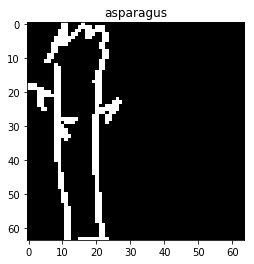

In [50]:
# Show an image
ind = 100
plt.imshow(train_df.iloc[ind]['img'],cmap='gray')
plt.title(train_df.iloc[ind]['word'])
plt.show()

# Create a baseline CNN

In [51]:
batch_size = 10
num_classes = len(fnames)
epochs = 12

### Data Preprocessing

In [52]:
# Shuffle the data
random.seed(111)
train_df = train_df.sample(train_df.shape[0])

In [53]:
# input image dimensions
img_rows, img_cols = output_height, output_width
input_shape = (img_rows, img_cols)

In [54]:
# Reshape the array
imgArr = np.vstack(train_df['img'].values).flatten().reshape((train_df['img'].shape[0], img_rows, img_cols))
imgArr_test = np.vstack(test_df['img'].values).flatten().reshape((test_df['img'].shape[0], img_rows, img_cols))

In [55]:
# In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
imgArr = imgArr.reshape(imgArr.shape[0], img_rows, img_cols, 1).astype('float32')
imgArr_test = imgArr_test.reshape(imgArr_test.shape[0], img_rows, img_cols, 1).astype('float32')

In [56]:
y_train = train_df['word']

In [57]:
# Convert class labels from categorical to numerical
unique_classes_list = y_train.unique()
map_class_to_numeric = {k: v for v, k in enumerate(y_train.unique())}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}
y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train_numeric, num_classes)
num_classes = y_train_one_hot.shape[1]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(imgArr, y_train_one_hot, test_size=0.2)

In [59]:
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

### Model Architecture

In [60]:
num_filters = 8 # num of channels / filters
def baseline_conv_model(num_filters):
    model = Sequential()
    model.add(Conv2D(num_filters, (15,15), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (15,15), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))    
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model

In [61]:
model = baseline_conv_model(num_filters)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 50, 50, 8)         1808      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 8)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 16)        28816     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 400)               0         
__________

In [62]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50072 samples, validate on 12518 samples
Epoch 1/500
 - 836s - loss: 6.7617 - acc: 0.0028 - top_3_accuracy: 0.0088 - categorical_crossentropy: 6.7617 - val_loss: 5.8237 - val_acc: 0.0049 - val_top_3_accuracy: 0.0111 - val_categorical_crossentropy: 5.8237
Epoch 2/500
 - 856s - loss: 5.7710 - acc: 0.0061 - top_3_accuracy: 0.0162 - categorical_crossentropy: 5.7710 - val_loss: 5.7182 - val_acc: 0.0099 - val_top_3_accuracy: 0.0249 - val_categorical_crossentropy: 5.7182
Epoch 3/500
 - 829s - loss: 5.6591 - acc: 0.0128 - top_3_accuracy: 0.0313 - categorical_crossentropy: 5.6591 - val_loss: 5.5556 - val_acc: 0.0171 - val_top_3_accuracy: 0.0419 - val_categorical_crossentropy: 5.5556
Epoch 4/500
 - 831s - loss: 5.4935 - acc: 0.0210 - top_3_accuracy: 0.0499 - categorical_crossentropy: 5.4935 - val_loss: 5.3602 - val_acc: 0.0278 - val_top_3_accuracy: 0.0635 - val_categorical_crossentropy: 5.3602
Epoch 5/500
 - 836s - loss: 5.2814 - acc: 0.0279 - top_3_accuracy: 0.0661 - categorical_crosse

KeyboardInterrupt: 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [65]:
import pillow

ImportError: No module named pillow

In [131]:
# X_train.shape

(27200, 50, 50, 1)